## 03 - Image filtering using the convolution operator



In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

In the previous notebooks, image enhancement was achieved by taking as input only some given pixel evaluated at a coordinate $f(x,y)$. *Image filtering* considers a neighbourhood around the pixel to be processed, i.e. a region of pixels centred at coordinate $(x,y)$. Therefore, it produces a combination of neighbour pixels. When this combination is linear, we can write this transformation by means of a **convolution** operator.

The convolution operator is formally written with the star operator `*`, allowing to differentiate it from a simple pixel-wise product. In terms of the whole image, it is given by:

$$ g = w * f$$

The equation above means the filtered (processed) image $g$ is obtained by a convolution of a processing element *w* (that defines the transformation) with the input image $f$. Note that now *w* will guide the way the transformation occurs. This processing element is called **filter** and it is organized as an array of weights.

The convolution evaluated at some given coordinate $(x,y)$ filters a pixel of image $f$, producing a new pixel value, $g(x,y)$:

$$ g(x,y) = \sum_{s=-a}^{a} \sum_{t=-b}^{b} w(s,t) \cdot f(x-s, y-t)$$

Note that for every value of $s$ and $t$ that indexes the filter $w(s,t)$, the convolution basically multiplies every value in $w$ with different positions around $f(x,y)$, using shifts defined by $s$ and $t$. 

Usually the filter is much smaller than $f$. Let us say $w$ has size `m x n` and $f$ is `M x N`. Another important remark is that this equation assumes the filter is centred at the origin $(0,0)$, thus the negative values of $s$ and $t$. 

Then, in order to process all values we want to make sure that: $m = 2a+1$ and $n = 2b+1$.

Therefore, $a = \frac{m-1}{2}$, $b = \frac{n-1}{2}$, allowing to index from $-a$ to $a$ (centred at 0) and from $-b$ to $b$ (also centred at 0).

Let us make an example with small matrices.

In [2]:
np.random.seed(666) # defining a seed
# random image with 5x5 size
f = np.random.randint(0,7, [5,5])
print(f)


[[4 2 5 6 6]
 [6 1 6 4 5]
 [3 6 3 4 4]
 [6 1 0 6 0]
 [5 2 4 5 5]]


In [3]:
# let us design some arbitrary filter *w* with size 3x3
w = np.matrix([[1, 2, 0], [1, 4, 0], [0, 0, 0]])/8.0
print(w)

[[0.125 0.25  0.   ]
 [0.125 0.5   0.   ]
 [0.    0.    0.   ]]


We wish to compute the convolution of $w$ with $f$, producing a new matrix/image $g$. In order to do so, we shall first understand how to compute the value of $g$ at a given pixel, for example $g(1,2)$.

The input central value is $f(1,2) = 6$.

The designed filter has size $3\times 3$ and therefore, $m=n=3$. 

Let us compute the values of $a$ and $b$ which are the indices for the convolution double sum. In the general form that would be:
$$ n = 2a + 1$$
$$ 2a= n - 1$$
$$ a = \frac{n-1}{2} $$

Plugging in the value of $n$
$$ 3 = 2a + 1$$
$$ 2a= 3 - 1$$
$$ a = \frac{2}{2} = 1 $$

Therefore:

$$ g(1,2) = \sum_{s=-1}^{1} \sum_{t=-1}^{1} w(s,t) \cdot f(1-s, 2-t)$$

Remember the equation considers that $w$ is centred at $(0,0)$, therefore the **indices** of filter $w$, are defined mathematically as follows:

$$ \begin{bmatrix}
 (-1,-1) & (0,-1) & (1,-1) \\ 
 (-1, 0) & (0, 0) & (1, 0) \\ 
 (-1, 1) & (0, 1) & (1, 1) 
\end{bmatrix}$$

Note that, in the code we dont have negative indices for arrays, so we are going to make some trick in that sense. But first, let us compute the convolution manually.

In practice what the equation performs is to take every value in $w$, multiply it by the neighbours of $f(1,2)$, and sum all resulting values.

So, we want to evaluate all terms $w(s,t) \cdot f(1-s, 2-t)$: 

The first term of the double sum is for $t = -1$ and $s = -1$ (those are in parenthesis below):
$$ w(-1,-1) \cdot f(1- (-1) ,2- (-1)) = 0.125 \cdot f(2,3)$$

The second term, $t=-1, s=0$:
$$ w(-1, 0) \cdot f(1-(-1),2-(0)) = 0.125 \cdot f(2,2)$$

The third term, $t=-1, s=1$:
$$ w(-1, 1) \cdot f(1-(-1),2-(1)) = 0.0 \cdot f(2,1)$$

The forth term, $t=0, s=-1$:
$$ w(0,-1) \cdot f(1-(0),2-(-1)) = 0.25 \cdot f(1,3)$$

And so on. Note the three first values of the filter are related to the **first column** of the filter : `[0.125, 0.125 , 0.0  ]`. Those are multiplying the values at the **second row** of the image, but in inverted order, at coordinates:(2,3), (2,2) and (2,1) relative to the values: `[4, 3, 6]` (look for this sequence in the second row of the image, but in inverted order, that is due to the subtraction 1-s and 2-t on the definition of convolution)

Therefore, the convolution performs a point-wise multiplication between the image pixels, centred at $(x,y)$, and the values of the *flipped filter*. This flipping may not make much sense in terms of image processing (whose information is spatial), but it does in terms of signal processing (time information), from which the definition of convolution comes from.

Therefore, let us make the implementation easier by flipping the filter first.

In [4]:
wf = np.flip( np.flip(w,0) , 1)
print(wf)

[[0.    0.    0.   ]
 [0.    0.5   0.125]
 [0.    0.25  0.125]]


Now we can just run a point-wise multiplication centred at (x,y)

In [5]:
# knowing we want to compute g(1,2), let us extract just the part of the matrix we need
x = 1
y = 2
# using the a and b calculated before, we want the region x-1 to x+1, y-1 to y+1.
# but, in Python the interval -A:B creates a sequence [A, A+1, A+2, ..., B-2, B-1], therefore we use 2 at the end
# let us print the neighbourhood of (x=1,y=2)
print(f[ x-1:x+2 , y-1:y+2 ])

[[2 5 6]
 [1 6 4]
 [6 3 4]]


In [6]:
# first, perform a point-wise multiplication between the region and the flipped filter
conv1 = np.multiply(f[ x-1:x+2 , y-1:y+2 ], wf)
conv1

matrix([[0.  , 0.  , 0.  ],
        [0.  , 3.  , 0.5 ],
        [0.  , 0.75, 0.5 ]])

In [7]:
# then we sum every resulting value
g_1_2 = np.sum(conv1)
g_1_2

4.75

In [8]:
# this sum may be then converted to an integer value, by rounding the number (floor)
g_1_2 = int(np.sum(conv1))
g_1_2

4

In [9]:
# let us implement our own function that performs convolution at some pixel x,y
# assuming the filter has odd size (for n or m) to facilitate implementation
def conv_point(f, w, x, y, debug=False):
    n,m = w.shape
    a = int((n-1)/2)
    b = int((m-1)/2)
    # gets submatrix of pixel neighbourhood
    sub_f = f[ x-a : x+a+1 , y-b:y+b+1 ]

    # flips the filter
    w_flip = np.flip( np.flip(w, 0) , 1)
    
    # conditional for debugging the function by showing the arrays
    if (debug==True):
        print("sub-image f:\n" + str(sub_f))
        print("\nflipped filter w:\n" + str(w_flip))
    
    # performs convolution (without converting to int)
    value = np.sum( np.multiply(sub_f, w_flip))
    return value
    

In [10]:
# let us test it for some coordinate
conv_point(f, w, 3, 1)

1.5

Looks like it works! Now we may evaluate the convolution with $w$ on ALL pixels of $f$ and produce the filtered image $g$. To do that, let us implement a function

In [11]:
# performs convolution on all pixels of image f with filter w
def image_convolution(f, w, debug=False):
    N,M = f.shape
    
    # creates a new empty image to store processed values
    g = np.empty(f.shape, dtype=np.uint8)
    
    # loops through each pixel:
    for x in range(N):
        for y in range(M):
            # perform convolution converting to uint8
            g[x,y] = conv_point(f, w, x, y, debug).astype(np.uint8)


In [13]:
# using the function...
g = image_convolution(f, w)

ValueError: operands could not be broadcast together with shapes (0,0) (3,3) 

What should be the problem? It looked everything was ok. Let us use the debug argument as true to print out the matrices and filters.

In [ ]:
g = image_convolution(f, w, debug=True)

sub-image f:
[]

flipped filter w:
[[0.    0.    0.   ]
 [0.    0.5   0.125]
 [0.    0.25  0.125]]


ValueError: operands could not be broadcast together with shapes (0,0) (3,3) 

Note the function could not create a subimage $f$ for $f(0,0)$, because it tried to access **negative** index values. For exampel, for the filter we designed, $a = 1$ and $b = 1$, then the submatrix is given by:
    
`sub_f = f[ x-(a) : x+(a+1) , y-(b) : y+(b+1) ] 
       = f[ 0-(1) : 0+(1+1) , 0-(1) : 0-(1+1) ]
       = f[   -1  :      2  ,   -1  :      2  ]`

The interval contain regions of $f$ with index -1 at both row and collumn, which is out of the array bounds. Therefore, pixels at the border of the image cannot be computed in practice. Let us avoid them by processing only the pixels:

x from `0+a` to `N-a`

y from `0+b` to `M-b`

Ignoring border pixels for now. Since we are modifying the functions we can also compute the *flipped filter* only once and perform the convolution so we have a self-contained image convolution function

In [14]:
def image_convolution(f, w, debug=False):
    N,M = f.shape
    n,m = w.shape
    
    a = int((n-1)/2)
    b = int((m-1)/2)

    # flipped filter
    w_flip = np.flip( np.flip(w, 0) , 1)
    # new image to store filtered pixels
    g = np.zeros(f.shape, dtype=np.uint8)

    # for every pixel
    for x in range(a,N-a):
        for y in range(b,M-b):
            # gets subimage
            sub_f = f[ x-a : x+a+1 , y-b:y+b+1 ]
            if (debug==True):
                print(str(x)+","+str(y)+" - subimage:\n"+str(sub_f))
            # computes g at (x,y)
            g[x,y] = np.sum( np.multiply(sub_f, w_flip)).astype(np.uint8)

    return g

In [15]:
g = image_convolution(f, w)
print(g)

[[0 0 0 0 0]
 [0 3 4 4 0]
 [0 3 2 4 0]
 [0 1 2 4 0]
 [0 0 0 0 0]]


An alternative to not produce zero values at the borders is to maintain the original values.

In [16]:
def image_convolution(f, w, debug=False):
    N,M = f.shape
    n,m = w.shape
    
    a = int((n-1)/2)
    b = int((m-1)/2)

    # flipped filter
    w_flip = np.flip( np.flip(w, 0) , 1)
    # new image to store filtered pixels
    # copies the original image 'f' so that border pixels remain the same
    g = np.array(f, copy=True)

    # for every pixel
    for x in range(a,N-a):
        for y in range(b,M-b):
            # gets subimage
            sub_f = f[ x-a : x+a+1 , y-b:y+b+1 ]
            if (debug==True):
                print(str(x)+","+str(y)+" - subimage:\n"+str(sub_f))
            # computes g at (x,y)
            g[x,y] = np.sum( np.multiply(sub_f, w_flip)).astype(np.uint8)

    return g

In [17]:
g = image_convolution(f, w)
print(g)

[[4 2 5 6 6]
 [6 3 4 4 5]
 [3 3 2 4 4]
 [6 1 2 4 0]
 [5 2 4 5 5]]


A widely used strategy is to *extend the original image* to allow processing all pixels, even the border.

**Zero-padding**: the original image is 'framed' by filling the extra rows and columns with zero values. After performing convolution, we crop $g$ to its original volume. As an exercise, modify the convolution function to allow this method as an option.

### Filtering images

Filters can be designed with different purposes. 
The most commoly used filters are: **smoothing** filters, that produces images with less local variation, reducing noise, but also suppressing small details and texture; and **differential** filters, that work as derivative operator, which may be used to detect local transitions, enhance local variation, increasing details and noise if present in the image. 

Let us show some examples

In [18]:
img1 = imageio.imread("images/pattern.png")
img2 = imageio.imread("images/gradient_noise.png")
img3 = imageio.imread("images/board.jpg")

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  """Entry point for launching an IPython kernel.
C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  
C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-

In [19]:
# an average filter, producing a mean in region 3x3 (symmetric) considering all neighbours
w_mean = np.matrix([[1, 1, 1], [1, 1, 1], [1, 1, 1]])/9.0
print(w_mean)

[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]


(-0.5, 319.5, 319.5, -0.5)

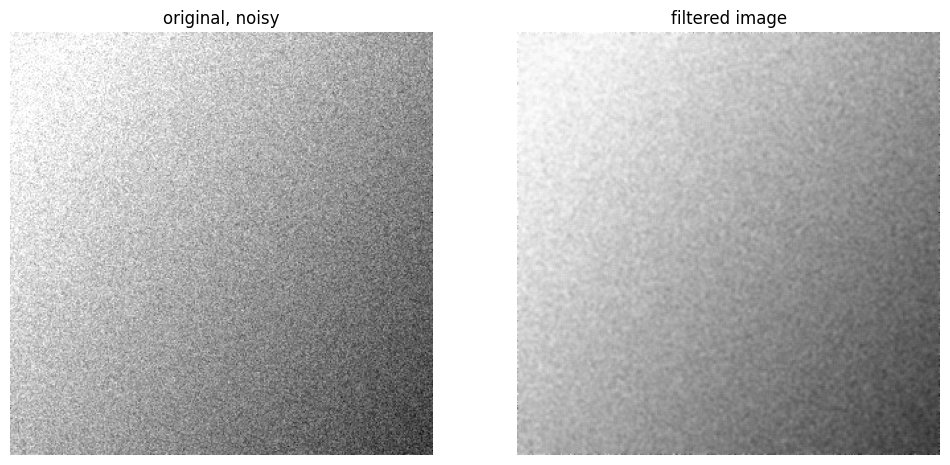

In [20]:
img2_mean = image_convolution(img2, w_mean)

# showing images
plt.figure(figsize=(12,12)) 
plt.subplot(121)
plt.imshow(img2, cmap="gray", vmin=0, vmax=255)
plt.title("original, noisy")
plt.axis('off')
plt.subplot(122)
plt.imshow(img2_mean, cmap="gray", vmin=0, vmax=255)
plt.title("filtered image")
plt.axis('off')

Note that the filtered image has pixels on the border that were kept from the original image because we cannot process the *a* pixels on the border (given by $a = (m-1)/2$), where *m* is the filter size.

When the filter has lateral size $3$, then $a = 1$ so we have a border size 1.

If we had a larger filter, say with laterl size $n,m=7$, then $a,b=3$ and 3 border pixels are not going to be processed. As exercise, design a filter $7\times 7$ or larger to see this effect.

Let us design other filters. First, a differential filter, and then a random filter.

[[ 0 -1  0]
 [-1  4 -1]
 [ 0 -1  0]]


(-0.5, 255.5, 255.5, -0.5)

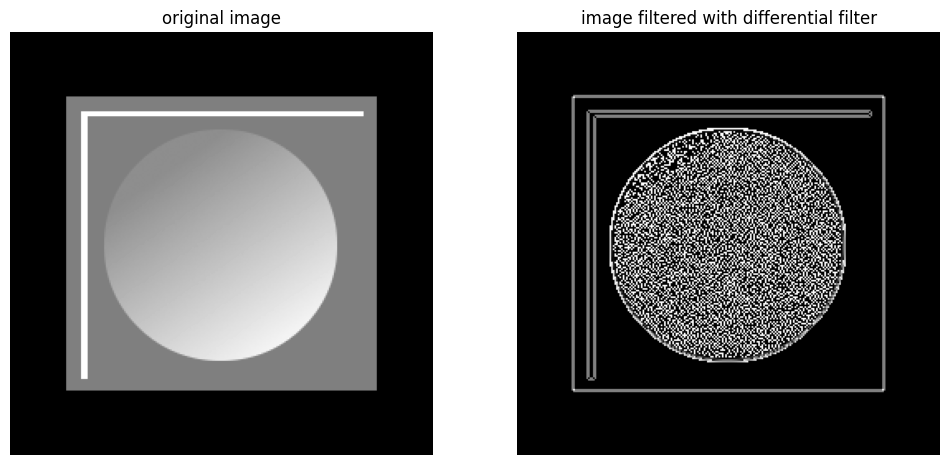

In [21]:
w_diff = np.matrix([[ 0, -1,  0], 
                    [-1,  4, -1], 
                    [ 0, -1,  0]])
print(w_diff)

img1_diff = image_convolution(img1, w_diff)

plt.figure(figsize=(12,12)) 
plt.subplot(121)
plt.imshow(img1, cmap="gray", vmin=0, vmax=255)
plt.title("original image")
plt.axis('off')
plt.subplot(122)
plt.imshow(img1_diff, cmap="gray", vmin=0, vmax=255)
plt.title("image filtered with differential filter")
plt.axis('off')

[[-1  0  1]
 [-1  0  1]
 [-1  0  1]]


(-0.5, 255.5, 255.5, -0.5)

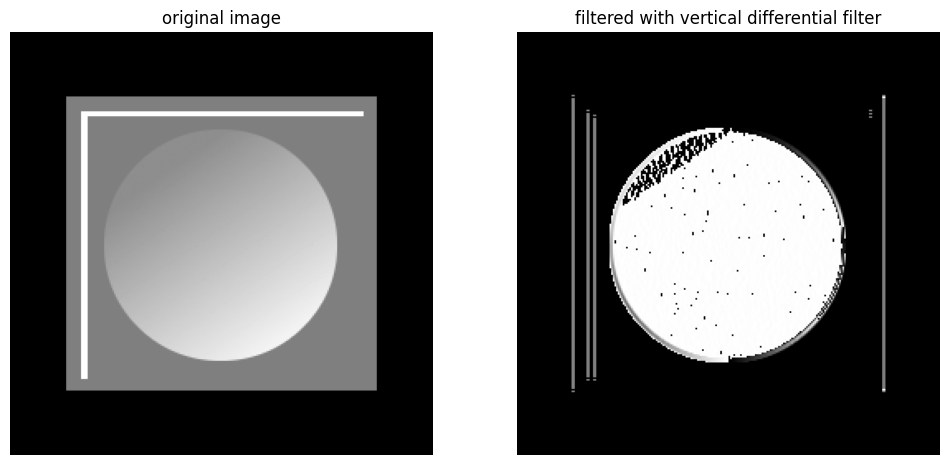

In [22]:
# another differential filter, but directional (vertical)
w_vert = np.matrix([[-1, 0, 1], 
                    [-1, 0, 1], 
                    [-1, 0, 1]])
print(w_vert)

img1_vert = image_convolution(img1, w_vert)

plt.figure(figsize=(12,12)) 
plt.subplot(121)
plt.imshow(img1, cmap="gray", vmin=0, vmax=255)
plt.title("original image")
plt.axis('off')
plt.subplot(122)
plt.imshow(img1_vert, cmap="gray", vmin=0, vmax=255)
plt.title("filtered with vertical differential filter")
plt.axis('off')

If you inspect the filters above, they all are designed to produce some type of effect in terms of diffusing the pixel values (smoothing, e.g. mean filter) or detecting transitions (differential filters, e.g. vertical borders).

But what if we have a *random filter*?

[[0.15551206 0.73460987 0.73159555 0.8578588  0.76741234 0.95323137
  0.29097383]
 [0.84778197 0.3497619  0.92389692 0.29489453 0.52438061 0.94253896
  0.07473949]
 [0.27646251 0.4675855  0.31581532 0.39016259 0.26832981 0.75366384
  0.66673747]
 [0.87287954 0.52109719 0.75020425 0.32940234 0.29130197 0.00103619
  0.6361797 ]
 [0.97933558 0.91236279 0.39925165 0.40322917 0.33454934 0.72306649
  0.96832961]
 [0.86766484 0.79123524 0.44446092 0.95619151 0.73353358 0.71210247
  0.2427146 ]
 [0.57043673 0.57773404 0.89274848 0.12138544 0.66083873 0.16459271
  0.09435837]]


(-0.5, 499.5, 464.5, -0.5)

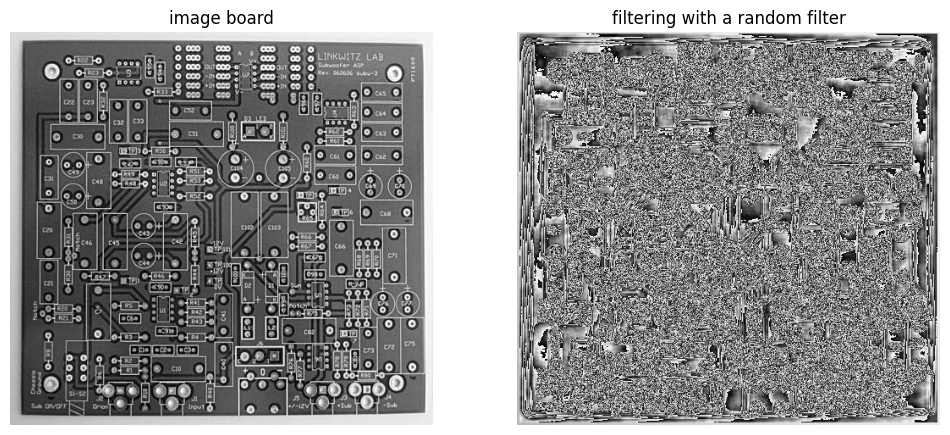

In [23]:
w_rand = np.random.random([7,7])
print(w_rand)
img3_wrand = image_convolution(img3, w_rand)

plt.figure(figsize=(12,12)) 
plt.subplot(121)
plt.imshow(img3, cmap="gray", vmin=0, vmax=255)
plt.title("image board")
plt.axis('off')
plt.subplot(122)
plt.imshow(img3_wrand, cmap="gray", vmin=0, vmax=255)
plt.title("filtering with a random filter")
plt.axis('off')

It does not look good! But is it an effect of the random filter or is there anything else wrong?

Our filter has positive values that sum up to much more than 1, the energy of the local regions will increase. This would, at first, increase only the brightness of the image. But, actually, because we are operating in 8 bits, the effect of such successive convolutions is *overflow* 


In [24]:
np.sum(w_rand)

27.54016871737443

We can fix that by, for example, normalizing the filter to sum 1.

[[0.02585711 0.0378494  0.03649521 0.0286427  0.02280824 0.00015623
  0.03533888]
 [0.01581176 0.01848789 0.00891704 0.02784535 0.00833245 0.00575785
  0.03333965]
 [0.0150308  0.02294278 0.03885615 0.01976385 0.01051783 0.01452737
  0.01172736]
 [0.03510083 0.00244295 0.00571199 0.03619847 0.01587506 0.02506887
  0.03653318]
 [0.01969933 0.00938521 0.02469278 0.03153196 0.03297276 0.02579698
  0.02409629]
 [0.00359831 0.01797674 0.02781251 0.00535474 0.01209256 0.0034193
  0.00692026]
 [0.00659087 0.01695693 0.03121676 0.01958983 0.00069732 0.04377973
  0.03988158]]


(-0.5, 499.5, 464.5, -0.5)

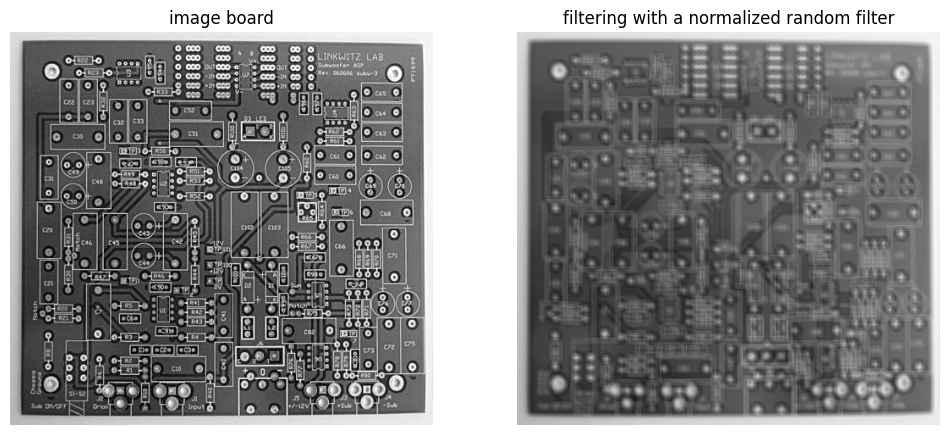

In [25]:
w_rand = np.random.random([7,7])
w_rand = w_rand/np.sum(w_rand)
print(w_rand)
img3_wrand = image_convolution(img3, w_rand)

plt.figure(figsize=(12,12)) 
plt.subplot(121)
plt.imshow(img3, cmap="gray", vmin=0, vmax=255)
plt.title("image board")
plt.axis('off')
plt.subplot(122)
plt.imshow(img3_wrand, cmap="gray", vmin=0, vmax=255)
plt.title("filtering with a normalized random filter")
plt.axis('off')

Now we can visualize the image, but note a random filter does not generate an useful image in terms of visualization, not even enhancing any specific characteristics. In fact this is a random smoothing filter, or random weighed mean filter.

Another possible random filter would be to create a random differential filter, normalizing it so that it contains negative and positive value, with zero sum. Try that as an exercise!

Therefore, we should design a filter carefully, in terms of the local transformation we want to achieve.

Inspect the implemented filters again, try to classify them in terms of which characteristics they enhance. Design other filters, varying the sizes and filtering images to see their effects.